In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Load the image
image_path = 'dataset/data/sudoku.png'
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Error: Unable to load image at {image_path}. Please check the path.")

In [96]:
# Convert the original image to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Convert the original image to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Specify the parameters for our HOG descriptor

cell_size = (8, 8)
block_size = (16, 16)
block_stride = (8, 8)
num_bins = 9


# Ensure `win_size` satisfies OpenCV conditions
height, width = img_gray.shape

# Compute the largest valid `win_size`
win_width = ((width - block_size[0]) // block_stride[0]) * block_stride[0] + block_size[0]
win_height = ((height - block_size[1]) // block_stride[1]) * block_stride[1] + block_size[1]
win_size = (win_width, win_height)


# Set the parameters of the HOG descriptor using the variables defined above
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

# Compute the HOG Descriptor for the gray scale image
hog_descriptor = hog.compute(img_gray)

print ('HOG Descriptor:', hog_descriptor)
print ('HOG Descriptor has shape:', hog_descriptor.shape)


HOG Descriptor: [0.25606513 0.01537703 0.04601376 ... 0.08963854 0.02995563 0.08873854]
HOG Descriptor has shape: (34596,)


In [ ]:
class IHOGVisualizer:
    
    def visualize_hog(self, img_gray, hog_descriptor):
        raise NotImplementedError("The method visualize_hog must be implemented in the derived class.")


class HOGFeatureExtractor:
    
    def __init__(self, cell_size=(8, 8), block_size=(16, 16), block_stride=(8, 8), num_bins=9):
        self.cell_size = cell_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.num_bins = num_bins


    def extract_hog(self, img_gray):
        height, width = img_gray.shape

        win_width = ((width - self.block_size[0]) // self.block_stride[0]) * self.block_stride[0] + self.block_size[0]
        win_height = ((height - self.block_size[1]) // self.block_stride[1]) * self.block_stride[1] + self.block_size[1]
        win_size = (win_width, win_height)

        hog = cv2.HOGDescriptor(win_size, self.block_size, self.block_stride, self.cell_size, self.num_bins)


        return hog.compute(img_gray), win_size
    

class HOGVisualizer(IHOGVisualizer):

    def __init__(self, cell_size=(8, 8), num_bins=9):
        self.cell_size = cell_size
        self.num_bins = num_bins

    def reshape_hog_descriptor(self, hog_descriptor, win_size,block_size, block_stride):
        """
        Reshapes the HOG descriptor based on the computed number of blocks.

        :param hog_descriptor: Flattened HOG descriptor array.
        :param win_size: Window size used for HOG computation.
        :return: Reshaped HOG descriptor.
        """
        num_blocks_x = (win_size[0] - self.block_size[0]) // self.block_stride[0] + 1
        num_blocks_y = (win_size[1] - self.block_size[1]) // self.block_stride[1] + 1

        num_cells_per_block_x = self.block_size[0] // self.cell_size[0]
        num_cells_per_block_y = self.block_size[1] // self.cell_size[1]

        expected_size = num_blocks_y * num_blocks_x * num_cells_per_block_y * num_cells_per_block_x * self.num_bins

        print(f"[DEBUG] win_size: {win_size}")
        print(f"[DEBUG] num_blocks_x: {num_blocks_x}, num_blocks_y: {num_blocks_y}")
        print(f"[DEBUG] num_cells_per_block_x: {num_cells_per_block_x}, num_cells_per_block_y: {num_cells_per_block_y}")
        print(f"[DEBUG] Expected HOG descriptor size: {expected_size}")
        print(f"[DEBUG] Actual HOG descriptor size: {hog_descriptor.shape[0]}")

        # Validate shape
        if hog_descriptor.shape[0] != expected_size:
            raise ValueError(f"Incorrect HOG descriptor size: expected {expected_size}, got {hog_descriptor.shape[0]}")

        # Correct reshaping
        return hog_descriptor.reshape(num_blocks_y, num_blocks_x, num_cells_per_block_y, num_cells_per_block_x, self.num_bins)

    
    def compute_gradients(self, hog_descriptor_reshaped):
        """
        Computes the average gradients for each cell.

        :param hog_descriptor_reshaped: Reshaped HOG descriptor.
        :return: Averaged gradient per cell and histogram counter.
        """
        num_cells_y, num_cells_x, _, _, _ = hog_descriptor_reshaped.shape

        avg_grad_per_cell = np.zeros((num_cells_y, num_cells_x, self.num_bins))
        hist_counter = np.zeros((num_cells_y, num_cells_x, 1))

        for i in range(2):
            for j in range(2):
                avg_grad_per_cell[i:num_cells_y:2, j:num_cells_x:2] += hog_descriptor_reshaped[i:num_cells_y:2, j:num_cells_x:2, :]
                hist_counter[i:num_cells_y:2, j:num_cells_x:2] += 1

        avg_grad_per_cell /= hist_counter
        print("[DEBUG] Computed gradient magnitudes for visualization.")

        return avg_grad_per_cell

    def plot_hog_features(self, img_gray, avg_grad_per_cell):
        """
        Plots the HOG feature visualization.

        :param img_gray: Original grayscale image.
        :param avg_grad_per_cell: Averaged gradient per cell.
        """
        len_vecs = avg_grad_per_cell.shape[0] * avg_grad_per_cell.shape[1] * avg_grad_per_cell.shape[2]
        angles = np.linspace(0, np.pi, self.num_bins, endpoint=False)

        U, V, X, Y = np.zeros(len_vecs), np.zeros(len_vecs), np.zeros(len_vecs), np.zeros(len_vecs)

        counter = 0
        for i in range(avg_grad_per_cell.shape[0]):
            for j in range(avg_grad_per_cell.shape[1]):
                for k in range(avg_grad_per_cell.shape[2]):
                    U[counter] = avg_grad_per_cell[i, j, k] * np.cos(angles[k])
                    V[counter] = avg_grad_per_cell[i, j, k] * np.sin(angles[k])
                    X[counter] = (self.cell_size[0] / 2) + (self.cell_size[0] * i)
                    Y[counter] = (self.cell_size[1] / 2) + (self.cell_size[1] * j)
                    counter += 1

        # Plot the results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Display the grayscale image
        ax1.set(title='Grayscale Image')
        ax1.imshow(img_gray, cmap='gray')

        # Plot the HOG descriptor
        ax2.set(title='HOG Descriptor')
        ax2.quiver(Y, X, U, V, color='white', headwidth=0, headlength=0, scale_units='inches', scale=3)
        ax2.invert_yaxis()
        ax2.set_aspect(aspect=1)
        ax2.set_facecolor('black')

        print("[DEBUG] HOG features plotted successfully.")
        plt.show()
    
    def visualize_hog(self, img_gray, hog_descriptor, win_size, block_size, block_stride):
        """
        Main function that orchestrates the visualization.

        :param img_gray: Grayscale image.
        :param hog_descriptor: Flattened HOG descriptor.
        :param win_size: Window size used for HOG computation.
        :param block_size: Block size used for HOG computation.
        :param block_stride: Block stride used for HOG computation.
        """
        hog_descriptor_reshaped = self.reshape_hog_descriptor(hog_descriptor, win_size, block_size, block_stride)
        avg_grad_per_cell = self.compute_gradients(hog_descriptor_reshaped)
        self.plot_hog_features(img_gray, avg_grad_per_cell)


        

In [ ]:
img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img_gray = cv2.equalizeHist(img_gray)  # Improve contrast

# Extract HOG Features
hog_extractor = HOGFeatureExtractor()
hog_descriptor, win_size = hog_extractor.extract_hog(img_gray)

# Visualize HOG Features
hog_visualizer = HOGVisualizer()
hog_visualizer.visualize_hog(img_gray, hog_descriptor, win_size)

AttributeError: 'HOGVisualizer' object has no attribute 'block_size'

In [93]:
# Load the image
image_path = 'dataset/van.jpeg'
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Error: Unable to load image at {image_path}. Please check the path.")

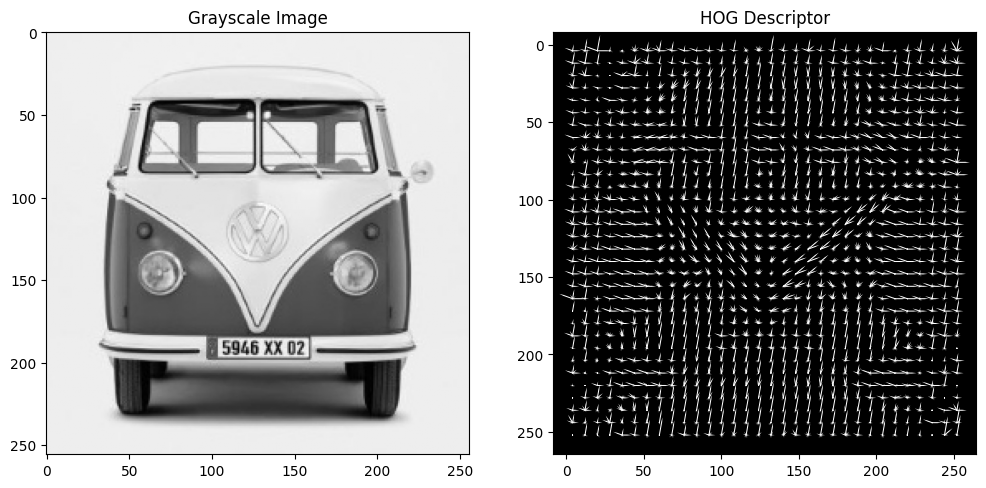

In [97]:
# Reshape the feature vector to [number of blocks in x and y direction, number of cells per block in x and y direction, number of bins]
# This will be useful later when we plot the feature vector, so that the feature vector indexing matches the image indexing
hog_descriptor_reshaped = hog_descriptor.reshape(31,
                                                 31,
                                                 2,
                                                 2,
                                                 9).transpose((1, 0, 2, 3, 4))

# Create an array that will hold the average gradients for each cell
ave_grad = np.zeros((32, 32, 9))

# Create an array that will count the number of histograms per cell
hist_counter = np.zeros((32, 32, 1))

# Add up all the histograms for each cell and count the number of histograms per cell
for i in range(2):
    for j in range(2):
        ave_grad[i:31 + i,
                 j:31 + j] += hog_descriptor_reshaped[:, :, i, j, :]

        hist_counter[i:31 + i,
                     j:31 + j] += 1

# Calculate the average gradient for each cell
ave_grad /= hist_counter

# Calculate the total number of vectors we have in all the cells.
len_vecs = ave_grad.shape[0] * ave_grad.shape[1] * ave_grad.shape[2]

# Create an array that has num_bins equally spaced between 0 and 180 degress in radians.
deg = np.linspace(0, np.pi, num_bins, endpoint=False)

# Each cell will have a histogram with num_bins. For each cell, plot each bin as a vector (with its magnitude
# equal to the height of the bin in the histogram, and its angle corresponding to the bin in the histogram).
# To do this, create rank 1 arrays that will hold the (x,y)-coordinate of all the vectors in all the cells in the
# image. Also, create the rank 1 arrays that will hold all the (U,V)-components of all the vectors in all the
# cells in the image. Create the arrays that will hold all the vector positons and components.
U = np.zeros((len_vecs))
V = np.zeros((len_vecs))
X = np.zeros((len_vecs))
Y = np.zeros((len_vecs))

# Set the counter to zero
counter = 0

# Use the cosine and sine functions to calculate the vector components (U,V) from their maginitudes. Remember the
# cosine and sine functions take angles in radians. Calculate the vector positions and magnitudes from the
# average gradient array
for i in range(ave_grad.shape[0]):
    for j in range(ave_grad.shape[1]):
        for k in range(ave_grad.shape[2]):
            U[counter] = ave_grad[i, j, k] * np.cos(deg[k])
            V[counter] = ave_grad[i, j, k] * np.sin(deg[k])

            X[counter] = (cell_size[0] / 2) + (cell_size[0] * i)
            Y[counter] = (cell_size[1] / 2) + (cell_size[1] * j)

            counter = counter + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display the image
ax1.set(title='Grayscale Image')
ax1.imshow(img_gray, cmap='gray')

# Plot the feature vector (HOG Descriptor)
ax2.set(title='HOG Descriptor')
ax2.quiver(Y, X, U, V, color='white', headwidth=0, headlength=0, scale_units='inches', scale=3)
ax2.invert_yaxis()
ax2.set_aspect(aspect=1)
ax2.set_facecolor('black')

In [98]:
# Write a function that plots the cell given its location, its gradients, the HOG image, and its histogram.
def zoom_hog_cell(cell_num_x, cell_num_y):
    x_min, x_max = cell_num_x*8,  (cell_num_x+1)*8
    y_min, y_max = cell_num_y*8,  (cell_num_y+1)*8

    img_cell = img_gray[y_min:y_max, x_min:x_max]

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30, 5))

    # Grayscale image
    ax1.set(title='Grayscale Image')
    ax1.imshow(img_gray, cmap='gray')
    rect = patches.Rectangle((x_min, y_min), 8, 8,
                             linewidth=2, edgecolor='r', facecolor='none')
    ax1.add_patch(rect)
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)

    # Cell image
    ax2.set(title='Cell')
    ax2.imshow(img_cell, cmap='gray')
    ax2.xaxis.set_ticks_position('none')
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)

    # Image gradients of the cell
    ax3.set(title='Gradients (Cell)')
    ax3.imshow(img_cell, cmap='gray')
    dY, dX = np.gradient(img_cell)
    ax3.quiver(dX, -dY, color='red')
    ax3.axes.xaxis.set_visible(False)
    ax3.axes.yaxis.set_visible(False)

    # Hog image of the cell
    ax4.set(title='HOG Image (Cell)')
    ax4.quiver(Y, X, U, V, color='white', headwidth=0, headlength=0,
               scale_units='inches', width=0.01, scale=0.3)
    ax4.set_xlim(x_min, x_max)
    ax4.set_ylim(y_min, y_max)
    ax4.invert_yaxis()
    ax4.set_aspect(aspect=1)
    ax4.set_facecolor('black')
    ax4.axes.xaxis.set_visible(False)
    ax4.axes.yaxis.set_visible(False)

    # Histogram of the gradients
    ax5.set(title='Histogram of Gradients (Cell)')
    angle_axis = np.linspace(0, 180, num_bins, endpoint=False)
    angle_axis += ((angle_axis[1] - angle_axis[0]) / 2)
    ax5.grid()
    ax5.set_xlim(0, 180)
    ax5.set_xticks(angle_axis)
    ax5.set_xlabel('Angle')
    ax5.bar(angle_axis, ave_grad[cell_num_y, cell_num_x, :], 180 //
            num_bins, align='center', alpha=0.5, linewidth=1.2, edgecolor='k')

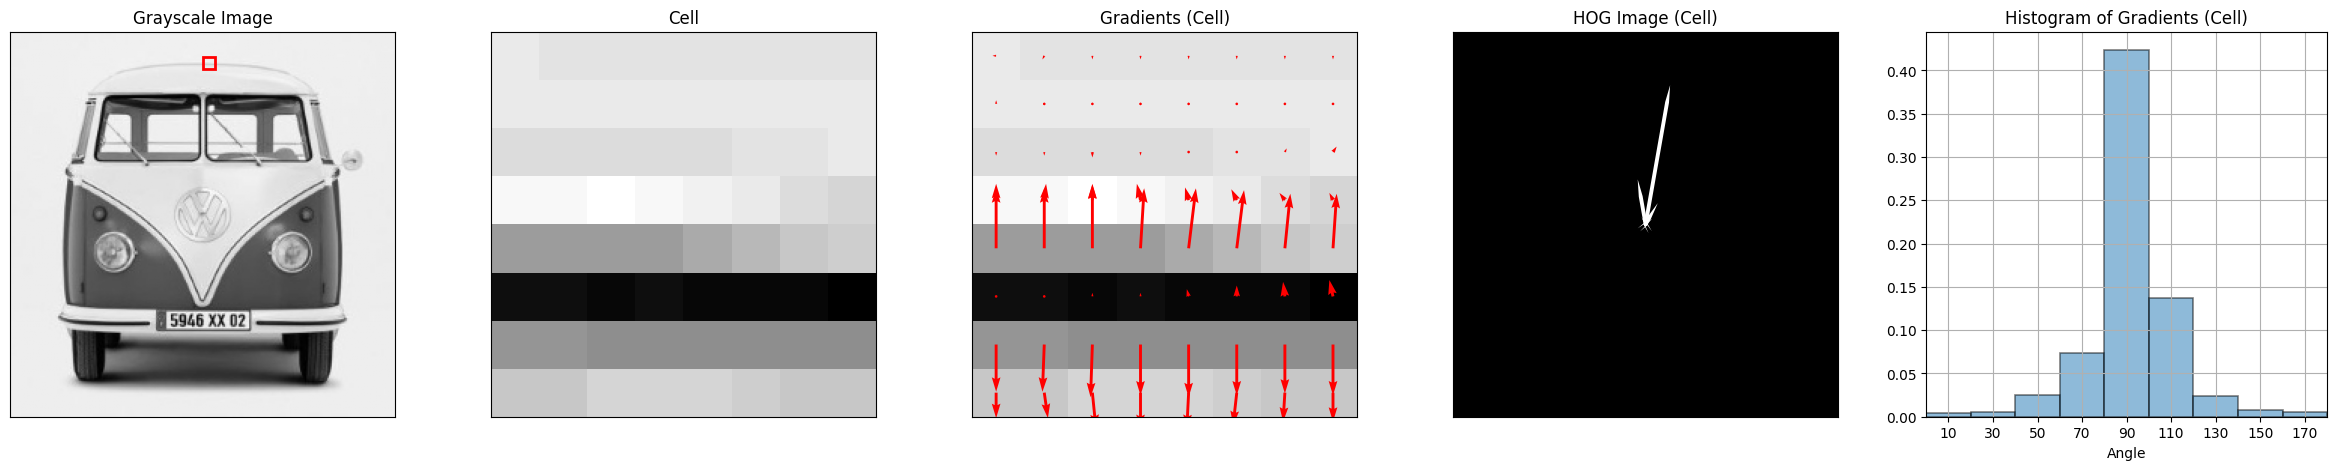

In [105]:
zoom_hog_cell(16, 2)